# Exploration 06

# 데이터 준비와 확인

In [461]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/LMS/Exploration/Ex.6/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/LMS/Exploration/Ex.6/data/ratings_test.txt')

print(len(train_data))
train_data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [462]:
print(len(test_data))
test_data.head()

50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 데이터로더 구성

## Konlpy 환경 설치

In [463]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [464]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [465]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141812 sha256=13f51358be9f5be36ef7bd941e9200459661d5dff89b41f114e4f1da59aaf670
  Stored in directory: /root/.cache/pip/wheels/40/7b/9f/2922869bef86c3354ae7034f7a3647c573ee1997c2dad0290a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
    Running setup.py install for mecab-python: started
    Running setup.py install for mecab-python: finished with status 'done'


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


## 나만의 data_loader 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전`word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [466]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    #사전 word_to_index구성    
    word_to_index = {word:index for index, word in enumerate(vocab)}

    #텍스트 스트링을 사전 인덱스 스트링으로 변환    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

숫자에서 문자 딕셔너리 생성

In [467]:
word_to_index["<PAD>"] = 0 # 패딩용 단어
word_to_index["<BOS>"] = 1 # 문장의 시작지점
word_to_index["<UNK>"] = 2 # 사전에 없는(Unknown) 단어

index_to_word = {index:word for word, index in word_to_index.items()}

### \<PAD>, \<BOS>, \<UNK> 추가

In [468]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [469]:
print(get_decoded_sentence(X_train[0], index_to_word))
print("라벨: ",y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences를 활용한 패딩 추가

### 데이터셋 내 문장 길이 분포

Text(0, 0.5, 'number of elements')

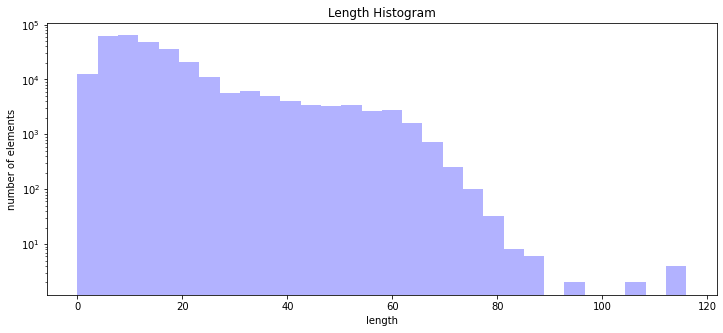

In [470]:
import matplotlib.pyplot as plt

len_by_token = [len(t) for t in list(X_train)+list(X_train)]
plt.figure(figsize = (12,5))

plt.hist(len_by_token, bins = 30, alpha = 0.3, color = 'b', label = 'word')

plt.yscale('log', nonposy = 'clip')
plt.title('Length Histogram')
plt.xlabel('length')
plt.ylabel('number of elements')

### 적절한 문장 길이 선정

In [471]:
import numpy as np
len_by_token = np.array(len_by_token)

print('문장 최대 길이: ',np.max(len_by_token))
print('문장 최소 길이 : ',np.min(len_by_token))
print('문장 평균 길이 : ',np.mean(len_by_token))
print('문장 길이 표준편차: ', np.std(len_by_token))
print('문장 중간 길이: ', np.median(len_by_token))
print('제 1사분위 길이 : ',np.percentile(len_by_token, 25))
print('제 3사분위 길이 : ',np.percentile(len_by_token, 75))

# 적절한 문장길이 - 최대길이 평균 + 2*표준편차
max_len = int(np.mean(len_by_token)+2*np.std(len_by_token))
print('\n적절한 문장길이 : {}'.format(max_len))

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
below_threshold_len(max_len, X_train)

문장 최대 길이:  116
문장 최소 길이 :  0
문장 평균 길이 :  15.981687211831826
문장 길이 표준편차:  12.824686694216712
문장 중간 길이:  12.0
제 1사분위 길이 :  7.0
제 3사분위 길이 :  19.0

적절한 문장길이 : 41
전체 샘플 중 길이가 41 이하인 샘플의 비율: 93.41711017772366


### Keras.preprocessing.sequence.pad_sequences를 활용한 패딩 추가

In [472]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value = word_to_index['<PAD>'],
                                                     padding = 'pre',
                                                     maxlen = max_len)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                     value = word_to_index['<PAD>'],
                                                     padding = 'pre',
                                                     maxlen = max_len)
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]


# 모델 구성 및 validation set 구성

## RNN 모델 설게 (시퀀스 형태의 데이터 처리에 최적)

In [473]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

RNNmodel = tf.keras.Sequential()
RNNmodel = tf.keras.Sequential()
RNNmodel.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
RNNmodel.add(tf.keras.layers.GlobalMaxPooling1D())
RNNmodel.add(tf.keras.layers.Dense(8, activation='relu'))
RNNmodel.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

RNNmodel.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 128)         1280000   
                                                                 
 global_max_pooling1d_17 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_34 (Dense)            (None, 8)                 1032      
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,281,041
Trainable params: 1,281,041
Non-trainable params: 0
_________________________________________________________________


### Train / validation set 분리

In [474]:
len(X_train)

146182

In [475]:
# validation set 70000건 분리
X_val = X_train[:70000]   
y_val = y_train[:70000]

# validation set을 제외한 나머지 76182건
partial_X_train = X_train[70000:]  
partial_y_train = y_train[70000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(76182, 41)
(76182,)


### 모델 훈련 개시

In [476]:
RNNmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = RNNmodel.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
149/149 [==============================] - 11s 67ms/step - loss: 0.5677 - accuracy: 0.7342 - val_loss: 0.3947 - val_accuracy: 0.8303
Epoch 2/10
149/149 [==============================] - 10s 67ms/step - loss: 0.3434 - accuracy: 0.8536 - val_loss: 0.3499 - val_accuracy: 0.8475
Epoch 3/10
149/149 [==============================] - 11s 72ms/step - loss: 0.2826 - accuracy: 0.8840 - val_loss: 0.3483 - val_accuracy: 0.8496
Epoch 4/10
149/149 [==============================] - 9s 59ms/step - loss: 0.2400 - accuracy: 0.9060 - val_loss: 0.3582 - val_accuracy: 0.8481
Epoch 5/10
149/149 [==============================] - 6s 38ms/step - loss: 0.2022 - accuracy: 0.9242 - val_loss: 0.3761 - val_accuracy: 0.8459
Epoch 6/10
149/149 [==============================] - 6s 39ms/step - loss: 0.1658 - accuracy: 0.9409 - val_loss: 0.4019 - val_accuracy: 0.8432
Epoch 7/10
149/149 [==============================] - 6s 39ms/step - loss: 0.1313 - accuracy: 0.9567 - val_loss: 0.4309 - val_accuracy: 0.8

In [477]:
results = RNNmodel.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5482 - accuracy: 0.8300 - 3s/epoch - 2ms/step
[0.5481610298156738, 0.8299530148506165]


### Loss, Accuracy 그래프 시각화

In [478]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


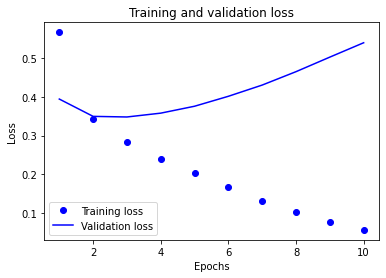

In [479]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

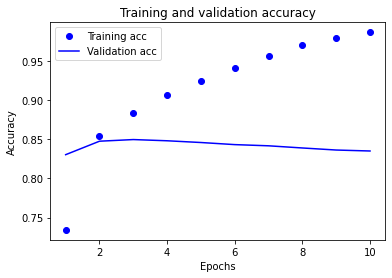

In [480]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1-D CNN을 이용 (병렬처리로 학습속도가 빠름)

In [481]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 128   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

CNNmodel = tf.keras.Sequential()
CNNmodel.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNNmodel.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNNmodel.add(tf.keras.layers.MaxPooling1D(5))
CNNmodel.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNNmodel.add(tf.keras.layers.GlobalMaxPooling1D())
CNNmodel.add(tf.keras.layers.Dense(8, activation='relu'))
CNNmodel.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNNmodel.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 128)         1280000   
                                                                 
 conv1d_14 (Conv1D)          (None, None, 16)          14352     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_18 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_36 (Dense)            (None, 8)               

In [482]:
CNNmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = CNNmodel.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
149/149 [==============================] - 23s 146ms/step - loss: 0.4986 - accuracy: 0.7524 - val_loss: 0.3625 - val_accuracy: 0.8395
Epoch 2/10
149/149 [==============================] - 21s 144ms/step - loss: 0.3170 - accuracy: 0.8652 - val_loss: 0.3430 - val_accuracy: 0.8505
Epoch 3/10
149/149 [==============================] - 24s 160ms/step - loss: 0.2615 - accuracy: 0.8950 - val_loss: 0.3526 - val_accuracy: 0.8502
Epoch 4/10
149/149 [==============================] - 22s 145ms/step - loss: 0.2034 - accuracy: 0.9242 - val_loss: 0.3769 - val_accuracy: 0.8480
Epoch 5/10
149/149 [==============================] - 22s 146ms/step - loss: 0.1416 - accuracy: 0.9510 - val_loss: 0.4348 - val_accuracy: 0.8435
Epoch 6/10
149/149 [==============================] - 22s 146ms/step - loss: 0.0915 - accuracy: 0.9709 - val_loss: 0.5031 - val_accuracy: 0.8382
Epoch 7/10
149/149 [==============================] - 22s 146ms/step - loss: 0.0596 - accuracy: 0.9821 - val_loss: 0.5711 - val_ac

In [483]:
results = CNNmodel.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.7925 - accuracy: 0.8253 - 5s/epoch - 3ms/step
[0.7924672365188599, 0.8252537846565247]


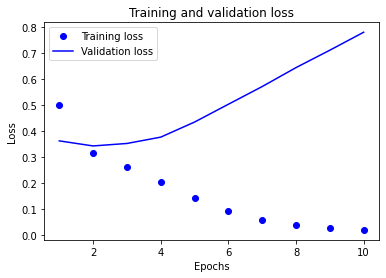

In [484]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

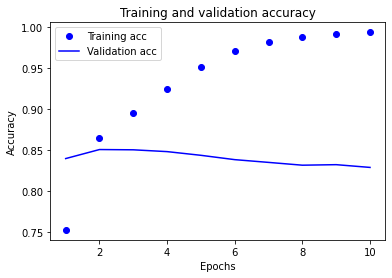

In [485]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GlovalMaxPooling1D 을 이용 (중요하다 생각되는 단어만 피처로 추출하여 학습)

In [486]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 128   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

MPmodel = tf.keras.Sequential()
MPmodel.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
MPmodel.add(tf.keras.layers.GlobalMaxPooling1D())
MPmodel.add(tf.keras.layers.Dense(8, activation='relu'))
MPmodel.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

MPmodel.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 128)         1280000   
                                                                 
 global_max_pooling1d_19 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_38 (Dense)            (None, 8)                 1032      
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,281,041
Trainable params: 1,281,041
Non-trainable params: 0
_________________________________________________________________


In [487]:
MPmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = MPmodel.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
596/596 [==============================] - 14s 23ms/step - loss: 0.4408 - accuracy: 0.8084 - val_loss: 0.3555 - val_accuracy: 0.8435
Epoch 2/10
596/596 [==============================] - 14s 24ms/step - loss: 0.3039 - accuracy: 0.8731 - val_loss: 0.3512 - val_accuracy: 0.8494
Epoch 3/10
596/596 [==============================] - 14s 23ms/step - loss: 0.2459 - accuracy: 0.9016 - val_loss: 0.3699 - val_accuracy: 0.8451
Epoch 4/10
596/596 [==============================] - 13s 23ms/step - loss: 0.1967 - accuracy: 0.9258 - val_loss: 0.3958 - val_accuracy: 0.8428
Epoch 5/10
596/596 [==============================] - 13s 23ms/step - loss: 0.1493 - accuracy: 0.9470 - val_loss: 0.4385 - val_accuracy: 0.8391
Epoch 6/10
596/596 [==============================] - 13s 23ms/step - loss: 0.1074 - accuracy: 0.9656 - val_loss: 0.4945 - val_accuracy: 0.8366
Epoch 7/10
596/596 [==============================] - 14s 23ms/step - loss: 0.0741 - accuracy: 0.9781 - val_loss: 0.5566 - val_accuracy:

In [488]:
results = CNNmodel.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.7925 - accuracy: 0.8253 - 5s/epoch - 3ms/step
[0.7924672365188599, 0.8252537846565247]


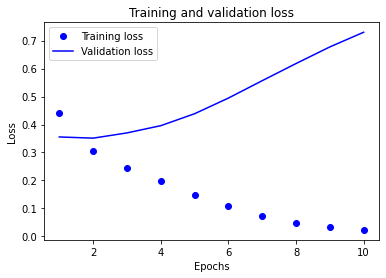

In [489]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

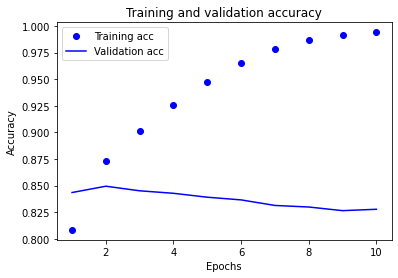

In [490]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 Embedding 레이어 분석

In [491]:
embedding_layer = RNNmodel.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [492]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/LMS/Exploration/Ex.6/data/word2vec.txt'

f = open(word2vec_file_path, 'w', encoding='utf-8')
f.write('{} {}\n'.format(10000-3, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 3개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = RNNmodel.get_weights()[0]
for i in range(3,10000):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [493]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import gensim


word2vec_path = '/content/drive/MyDrive/LMS/Exploration/Ex.6/data/ko.bin'
word2vec = word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [494]:
word2vec.similar_by_word("영화")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

# 한국어 Word2Vrc 임베딩 활용하여 성능 개선

In [512]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(3,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## RNN 이용

In [513]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 conv1d_20 (Conv1D)          (None, 35, 16)            22416     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 7, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d_23 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_46 (Dense)            (None, 8)               

In [514]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
149/149 [==============================] - 40s 267ms/step - loss: 0.6179 - accuracy: 0.6405 - val_loss: 0.5070 - val_accuracy: 0.7546
Epoch 2/4
149/149 [==============================] - 32s 213ms/step - loss: 0.4454 - accuracy: 0.7940 - val_loss: 0.4241 - val_accuracy: 0.8077
Epoch 3/4
149/149 [==============================] - 31s 210ms/step - loss: 0.3672 - accuracy: 0.8377 - val_loss: 0.4000 - val_accuracy: 0.8216
Epoch 4/4
149/149 [==============================] - 31s 210ms/step - loss: 0.3161 - accuracy: 0.8648 - val_loss: 0.3859 - val_accuracy: 0.8321


In [515]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3969 - accuracy: 0.8274 - 6s/epoch - 4ms/step
[0.3968776762485504, 0.8273694515228271]


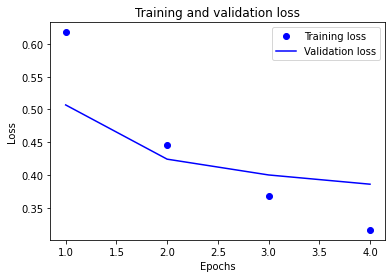

In [516]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

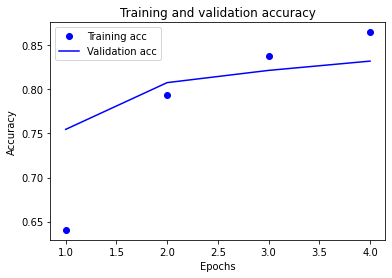

In [517]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1D CNN 이용

In [554]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 512   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

CNNmodel = tf.keras.Sequential()
CNNmodel.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNNmodel.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNNmodel.add(tf.keras.layers.MaxPooling1D(5))
CNNmodel.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNNmodel.add(tf.keras.layers.GlobalMaxPooling1D())
CNNmodel.add(tf.keras.layers.Dense(8, activation='relu'))
CNNmodel.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNNmodel.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, None, 512)         5120000   
                                                                 
 conv1d_32 (Conv1D)          (None, None, 16)          57360     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, None, 16)         0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_31 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_62 (Dense)            (None, 8)               

In [555]:
CNNmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=2  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = CNNmodel.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/2
298/298 [==============================] - 99s 327ms/step - loss: 0.4453 - accuracy: 0.7789 - val_loss: 0.3466 - val_accuracy: 0.8482
Epoch 2/2
298/298 [==============================] - 100s 335ms/step - loss: 0.2920 - accuracy: 0.8778 - val_loss: 0.3376 - val_accuracy: 0.8536


In [556]:
results = CNNmodel.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 11s - loss: 0.3454 - accuracy: 0.8507 - 11s/epoch - 7ms/step
[0.34535786509513855, 0.8507232069969177]


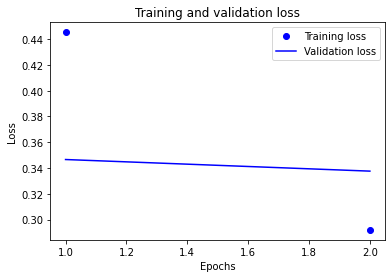

In [557]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

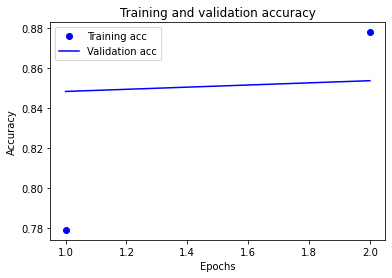

In [558]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## MaxPooling 이용

In [528]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 128   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

MPmodel = tf.keras.Sequential()
MPmodel.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
MPmodel.add(tf.keras.layers.GlobalMaxPooling1D())
MPmodel.add(tf.keras.layers.Dense(8, activation='relu'))
MPmodel.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

MPmodel.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 128)         1280000   
                                                                 
 global_max_pooling1d_26 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_52 (Dense)            (None, 8)                 1032      
                                                                 
 dense_53 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,281,041
Trainable params: 1,281,041
Non-trainable params: 0
_________________________________________________________________


In [529]:
MPmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = MPmodel.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
596/596 [==============================] - 19s 31ms/step - loss: 0.4661 - accuracy: 0.7842 - val_loss: 0.3606 - val_accuracy: 0.8419
Epoch 2/4
596/596 [==============================] - 17s 28ms/step - loss: 0.3125 - accuracy: 0.8684 - val_loss: 0.3483 - val_accuracy: 0.8482
Epoch 3/4
596/596 [==============================] - 16s 27ms/step - loss: 0.2556 - accuracy: 0.8979 - val_loss: 0.3595 - val_accuracy: 0.8482
Epoch 4/4
596/596 [==============================] - 14s 24ms/step - loss: 0.2068 - accuracy: 0.9215 - val_loss: 0.3871 - val_accuracy: 0.8457


In [530]:
results = MPmodel.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3953 - accuracy: 0.8422 - 2s/epoch - 2ms/step
[0.3952751159667969, 0.8421791195869446]


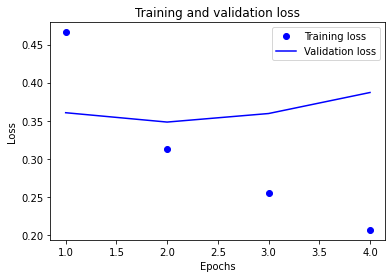

In [531]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

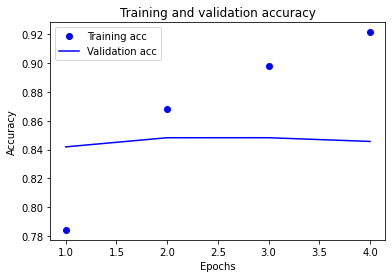

In [532]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

## 이번 프로젝트를 하며 어려웠던 점.
####이번 프로젝트를 진행하며, 가장 어려웠던것은 우선 시간분배였습니다.
- 사실, 지난 노드인 Exploration5번에서 필요 이상의 시간을 소모하여서, 이번 노드를 저번 노드만큼 깊게 들여다 보진 못했습니다.

####다음은 코드 분석 및 전처리가 어려웠습니다.
- 처음 시작할 때에는 어디서부터 건드려야할지 막막했기에, 우선 하나 하나 코드 분석을 하며 진행했습니다. 하지만 마지막 프로젝트 단계에서 주어진 코드들이 이해가 되지 않았고, 그부분에서 처음 막혔습니다. 하지만 하나하나 코드를 읽고, LMS에서 알려준 것들과 비교해가며, 또, 인터넷을 검색하여 embedding 이나, wrod2vec 등에 관한 지식을 읽고 오니 좀 더 코드와 진행하는 이해도가 좋아졌습니다. 주어진 코드 외에, 개인적으로 각 데이터 별 길이 배치 분포도가 궁금하여 그래프를 만들어보는데, 처음에 접근을 잘못하여 애를 많이 먹었습니다. 하지만 결국 원하는 그래프를 만들어내는데 성공하였고, 그래프를 통해 글의 길이를 어느정도 유추할 수 있어서 수월 했습니다.

#### 마지막으로는 정확도를 올리는것이 어려웠습니다.
- 나름 전처리를 깔끔하게 했다고 생각을 했고, 이전에 LMS에서 IMDB 영화 분석할 때에, google이 만들었다는 Word2Vec을 이용하였더니 정확도가 확 올라가는것을 보고, 저도 당연히 그렇게 될거라고 생각했습니다. 하지만 결과는 쉽지 않았습니다. 매 Exploration마다 느끼는 거지만.. 하이퍼 파라미터를 바꾸어 보아도, 결과가 다이나믹하게 바뀌지 않아, 어떤부분을 어떻게 바꿔야하는지 아직 감이 오지 않는점입니다.. 때문에, 나름의 다양한 시도와 가설을 갖고 하이퍼파라미터 값을 바꾸어 보았지만, 만족스러운 결과는 얻지 못해 아쉽습니다. 이 부분은 언젠가 꼭 계속해서 공부하여 상황에 맞춰 자유자제로 값을 찾아내는 감각을 기르고 싶습니다.

## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
#### 세 가지 모델을 사용하며 어느 에포그 시점부터 오버피팅 하였는지 그래프까지 보며 차이점을 비교할 수 있다는 점을 알아내었고, 때문에 직관적이됐지만, 여전히 정확도를 올리는 데에는 모호합니다.
- 이번 프로젝트를 진행하며, RNN, 1D CNN, 그리고 MaxPooling 모델까지 세 가지를 같은 데이터를 가지고 써 보았고, 각각의 하이퍼 파라미터 값도 바꾸어 가며 시도 해 보았습니다. 그리고 덧붙여, history_dict를 이용하여 오버피팅이 되는지를 그래프를 통해 직관적으로 볼 수 있다는 점이 즐거웠습니다. 다만, 그 값에 나름 맞추어서 값을 변경하여도, 오버피팅이 덜 될지는 몰라도, 정확도를 올리는 데에는 큰 변화를 주지 않았기에, 한편으론 점에 가깝지 않은 실선들이 원망스럽다고 느낄 때도 있기에 슬펐습니다. 때문에, 모호한점은, 정확도를 어떻게 올려야할지에 대한 감이 아직 잡히지 않았다는 점입니다. 물론, 데이터 전처리나 하이퍼 파라미터를 바꾸면 좀 더 개선할 수 있다는 이론은 얼추 알겠지만, 정확하게 어떤상황에 어떤값이, 어떤 모델이 어울리는지는 여전히 모호합니다.

#### 또한, 오버피팅 애포크 시점이, 고작 2번시도 이후 부터 라는 점 입니다.
- 이 점은 제가 해결해보기위해, 연관성을 높이면 괜찮을까? 싶어 word vector dimension을 바꾸어시도 해 보기도 하였고, batch size를 조절해 보기도 하였고, 또, train set과 validation set 구분의 정도도 시도해 보았습니다만 결과는 비슷하였습니다. 만약 애포크 5번 정도 이후부터라면, 애포크 값을 줄이겠지만, 2번 시도 이후부터 결과가 좋지않았기에, 애포크를 2로 둘 수 없어, 그냥 정확도가 올라가게끔 10정도로 두었습니다.

## 루브릭 평가 지표를 맞추기 위해 시도한 것들.
#### 하이퍼 파라미터 값을 다양하게 바꾸어 보았습니다.
- 바로 위에 설명하였지만, word vector dimension, batch size을 작게도시도, 큰값에도 시도해 보았지만, "적절한 값"이 무엇인지에 대한 의문은 아직 남아있습니다. 또한 train set, validation set의 분배를 나름의 기준을 두고 해 보았지만, 여전히 잘 모르겠습니다. 데이터 전처리를 조금 더 예쁘게 할 수 있는 방법이 있을까? 라는 생각은 하였지만, 지금 제가 한 기본 전처리가 적합하다는 생각을 하여 따로 건들지는 못하였습니다.

## 루브릭 평가 관련 지표를 달성하지 못했을 때 이유에 관한 추정.
#### 첫 번째로는 정확도 85% 이상을 겨우겨우 달성했기 때문이라 추정합니다.
- 결국 정확도 85%를 달성하긴 하였습니다. 하이퍼파라미터 값을 바꾸어도 매우 근사하게 바뀌다가 운이 좋게 얻어걸린 느낌입니다..  데이터 전처리, 그리고 word2Vec을 좀 더 잘 활용했더라면, 그리고 애포크 값, 하이퍼 파라미터 값 등을 잘 조절했더라면 달성할 수 있지 않았을까 추정해 봅니다.

#### 두 번째로는 그래프로 미루어보았을 때, 오버피팅이 많이 되어 보인다는 점 입니다.
- 애포크 1\~2 부터 벌써부터 오버피팅이 시작되었기에, 적당한 값에서 끊을 수가 없었습니다. 이로인한 궁금증이 생겼는데, 1~2 에서 오버피팅이 시작되면, 적절히 5정도만 하는게 좋은지, 아니면 정말 애포크 값을 1이나 2만 주어도 괜찮은지 궁금하게 되었습니다.

## 자기 다짐
#### 이번 프로젝트 뿐만이 아니라, 이번주의 노드들과 Exploration을 하며 시간 배분, 그리고 어떤식으로 공부를 하고 어떻게 Exploration을 받아드려야 하는지에 관한 감이 잡혔습니다. 이번주의 설 연휴를 잘 활용하여 밀린 노드들, 밀린 공부를 끝 내고, 다음주에는 좀 더 가치있는 수업 시간을 갖도록 하는것이 목표가 되었습니다. 

# 가장 잘 나온 정확도 (사진 첨부)

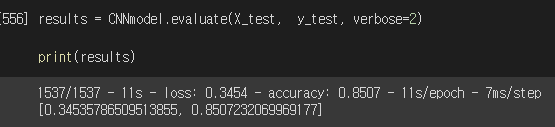